In [1]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.model_runner import evaluate_models, plot_predicted_vs_true, plot_regression_metrics, plot_residuals
from src.utils.preprocess import GeneExpPreprocessor
from src.utils.data_handler import DataHandler
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import spearmanr

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [2]:
GEP = GeneExpPreprocessor(auto_preprocess=False, top_N=500)
GEP._load_expr()
GEP._log1p_tpm_normalization()
GEP._subset()
all_exp = GEP.get_df()

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
pfs = metadata['Progress Free Survival (Months)']

n_patients = all_exp.index.get_level_values("patient_id").nunique()
n_samples = all_exp.index.get_level_values("sample_id").nunique()
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Subsetting to top 500 genes using method: dndscv
There are 1018 patients and 1132 samples in the dataset.


<h1>Align indices for df_exp and PFS</h2>

In [3]:
df_exp = all_exp.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df_exp.index.set_levels(
    df_exp.index.levels[1].map(truncate_sample_id),
    level=1
)

df_exp.index = new_index

<h1>Generate X and y</h1>

In [4]:
X = df_exp.copy()

# remove samples with nan pfs values
pfs = pfs.dropna()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(pfs.index)

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
pfs = pfs.loc[intersection_samples]
y = list(pfs)

# convert pfs to log1p scale
y = np.log1p(y)

Text(0.5, 1.0, 'Log1p Transformed PFS Distribution')

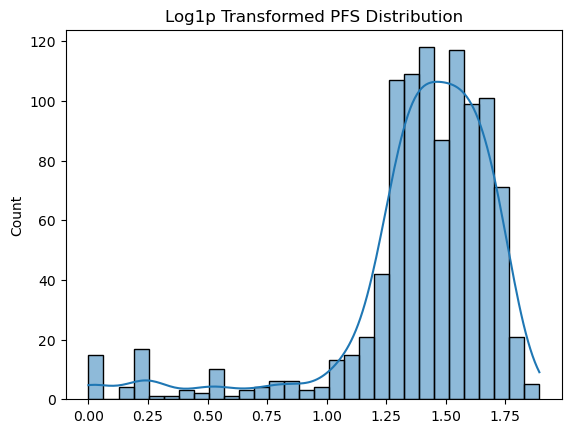

In [5]:
ax = sns.histplot(np.log1p(y), bins=30, kde=True)
ax.set_title('Log1p Transformed PFS Distribution')

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [6]:
def training_fold_filtering(X: pd.DataFrame, y: list[float], k: int) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Filter logic:
    1. Filter by mean expression across samples, keeping genes with a mean expression greater than 1.
    2. Choose top k features based on univariate feature selection using f_regression.
    """
    X = DH.filter_by_mean(X, 1)
    X = DH.filter_by_variance(X, 0.1)
    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

In [7]:
results = evaluate_models(X, y, filter_data=training_fold_filtering, k=2)

In [58]:
# evaluate models with different number of features
results = {}
for k in range(5, 101, 5):
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models(X, y, filter_data=training_fold_filtering, k=k)

Evaluating models with top 5 features...
Evaluating models with top 10 features...
Evaluating models with top 15 features...
Evaluating models with top 20 features...
Evaluating models with top 25 features...
Evaluating models with top 30 features...
Evaluating models with top 35 features...
Evaluating models with top 40 features...
Evaluating models with top 45 features...
Evaluating models with top 50 features...
Evaluating models with top 55 features...
Evaluating models with top 60 features...
Evaluating models with top 65 features...
Evaluating models with top 70 features...
Evaluating models with top 75 features...
Evaluating models with top 80 features...
Evaluating models with top 85 features...
Evaluating models with top 90 features...
Evaluating models with top 95 features...
Evaluating models with top 100 features...


In [59]:
# find the top 4 models based on spearman correlation
spearman_corrs = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['Spearman']['global'])
    spearman_corrs.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(spearman_corrs)[-3:][::-1]]

<h1>plot data</h1>

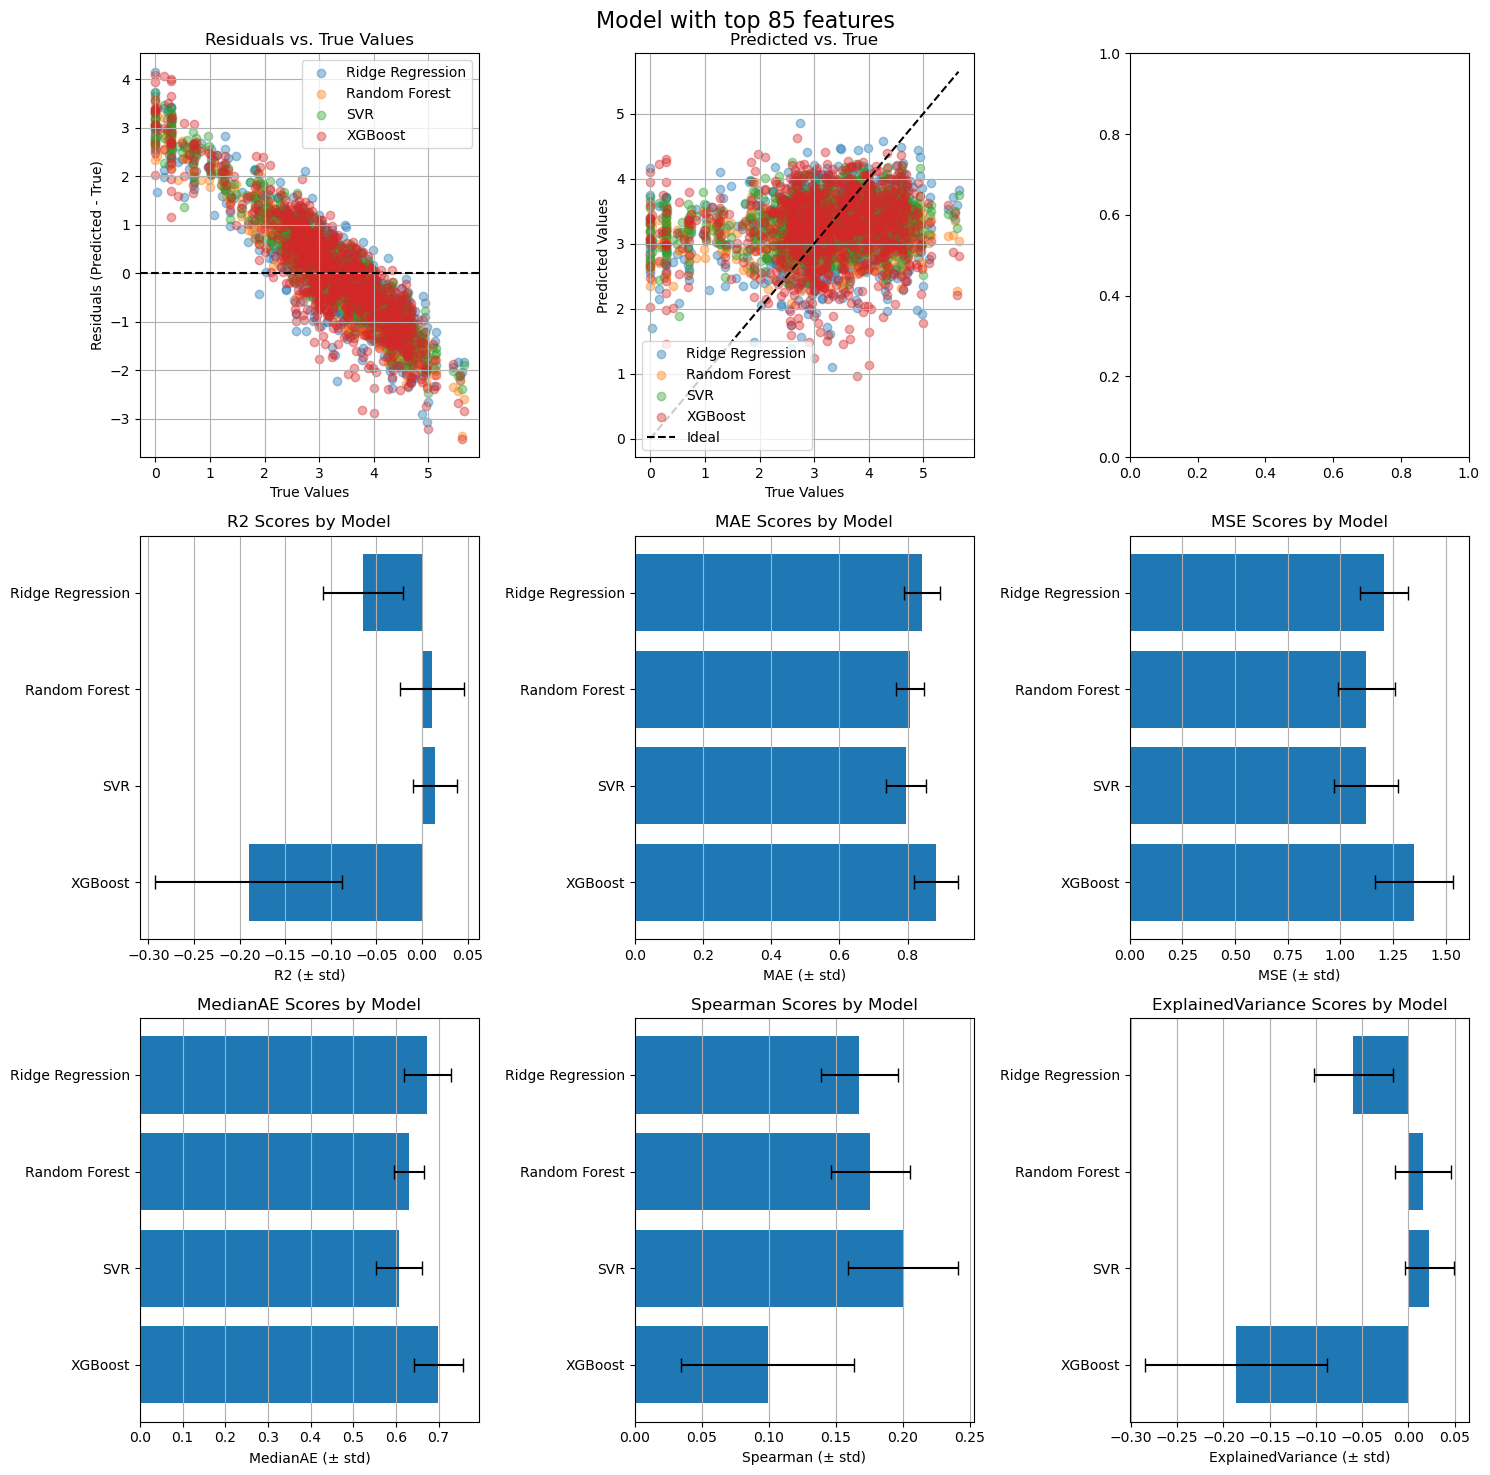

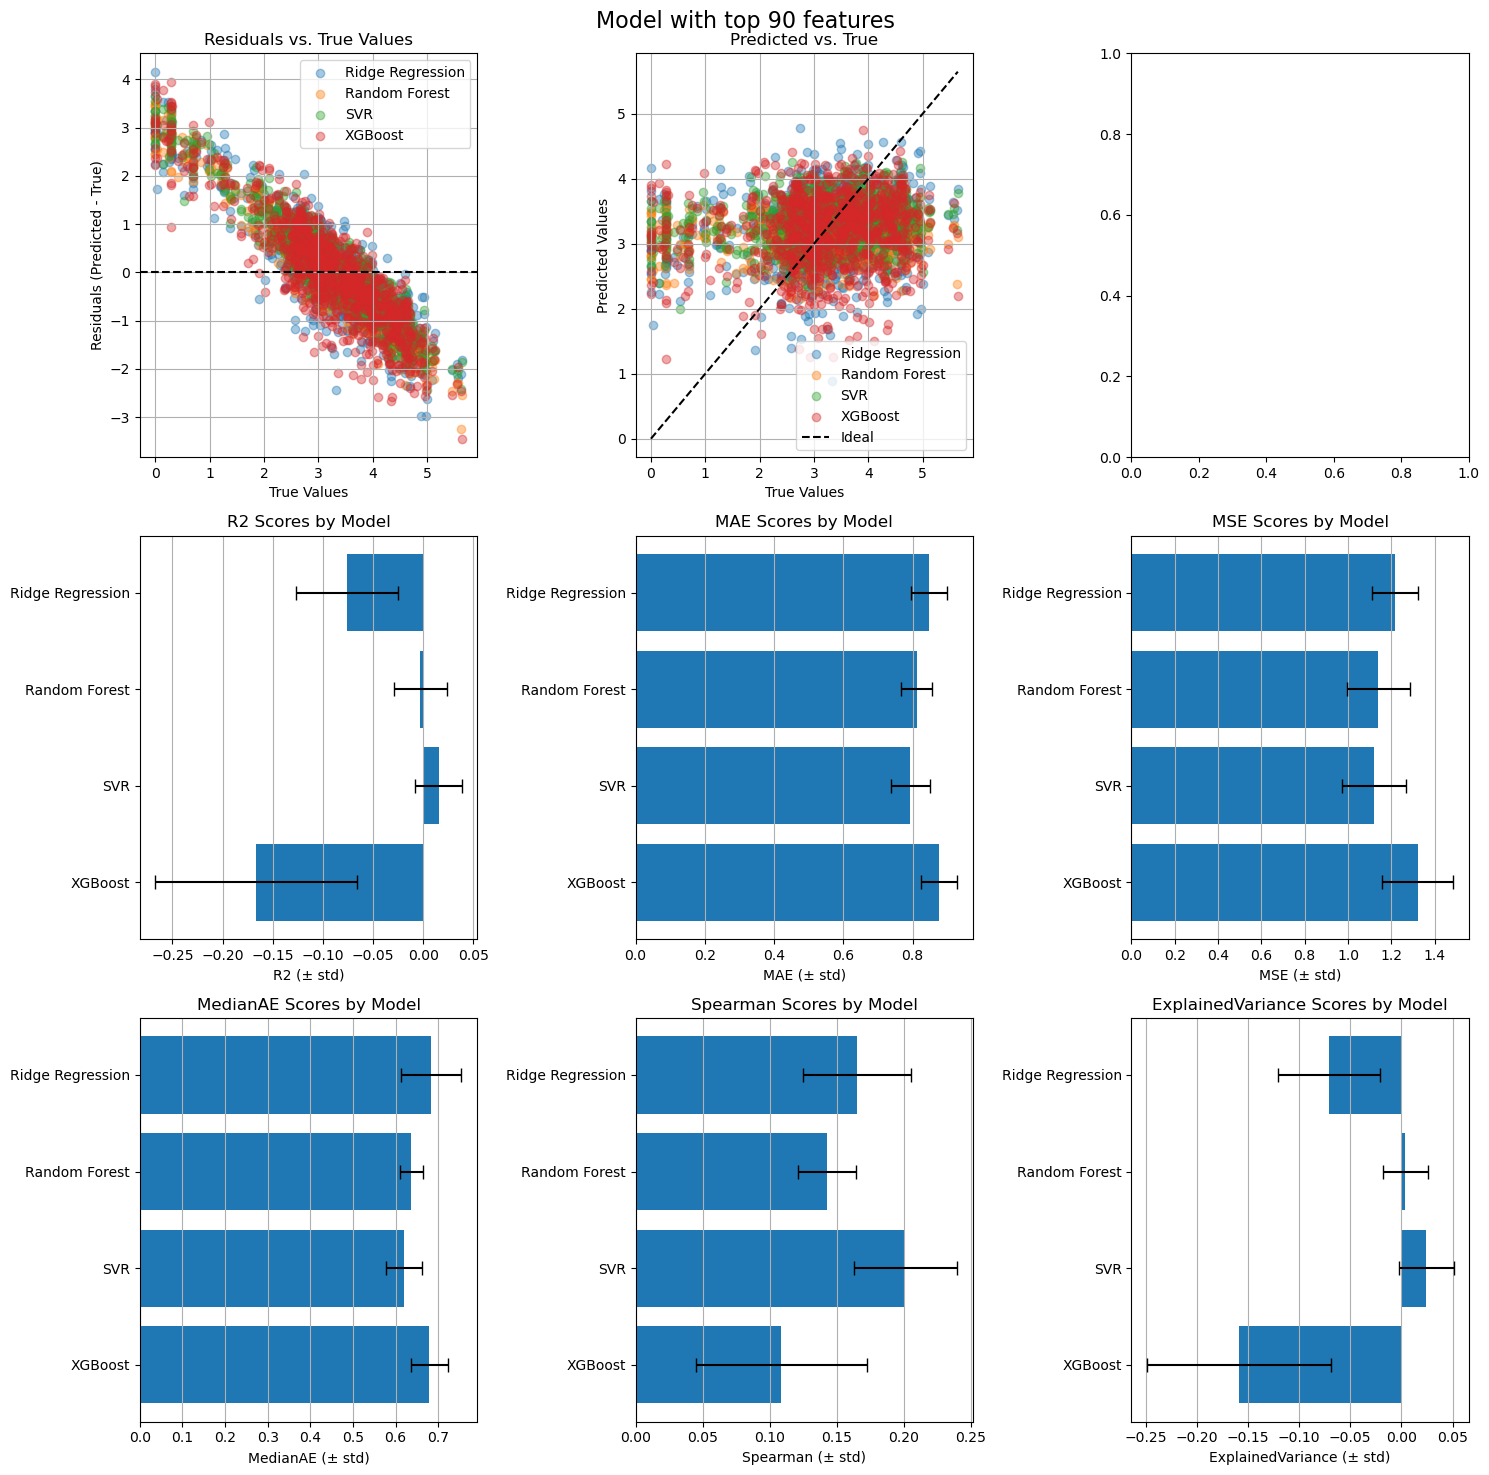

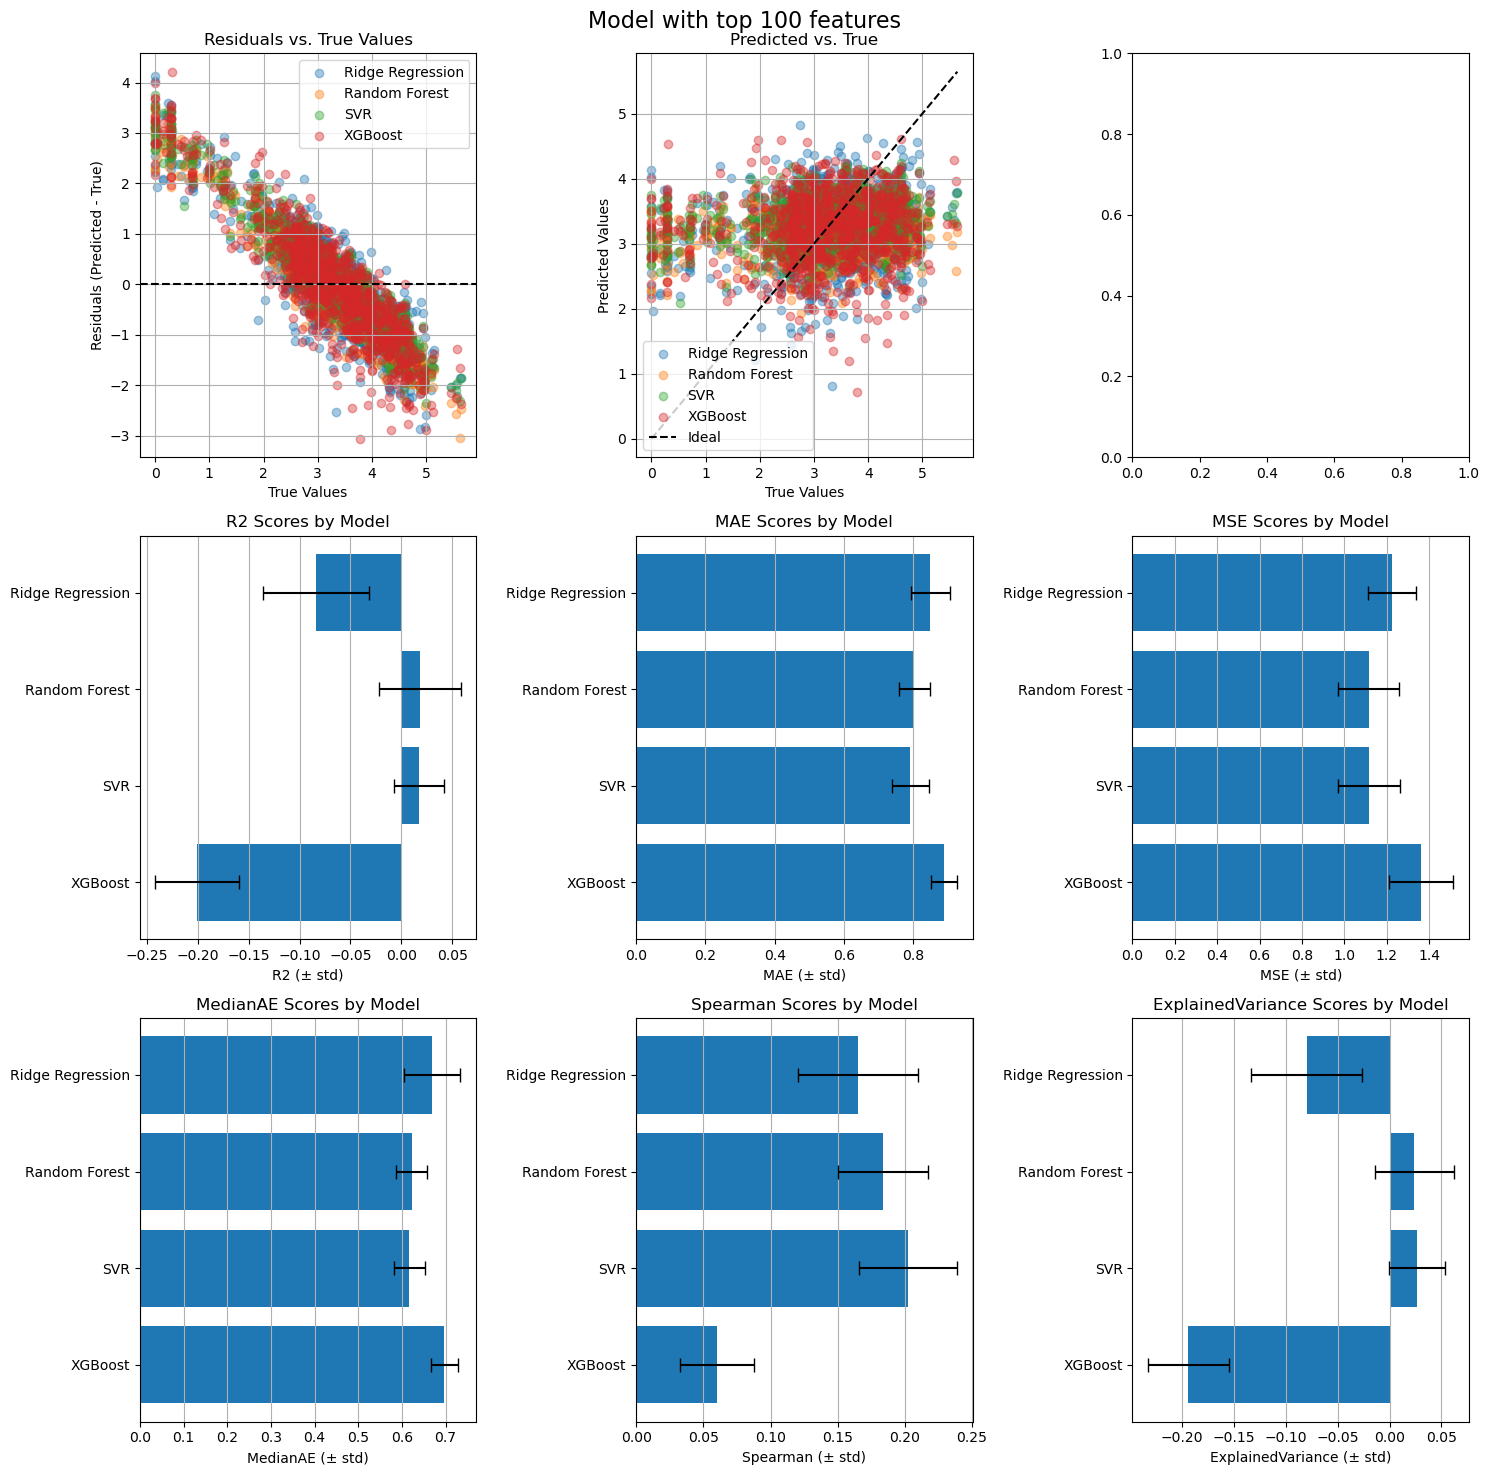

In [60]:
for k in top_k:
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    plot_residuals(results[k], ax=axes[0, 0])
    plot_predicted_vs_true(results[k], ax=axes[0, 1])
    plot_regression_metrics(results[k], ax=axes[1,0], metric='R2')
    plot_regression_metrics(results[k], ax=axes[1,1], metric='MAE')
    plot_regression_metrics(results[k], ax=axes[1,2], metric='MSE')
    plot_regression_metrics(results[k], ax=axes[2,0], metric='MedianAE')
    plot_regression_metrics(results[k], ax=axes[2,1], metric='Spearman')
    plot_regression_metrics(results[k], ax=axes[2,2], metric='ExplainedVariance')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

In [17]:
genes = results['XGBoost']['features']
spearman_scores = {
    gene: spearmanr(X[gene], y).correlation
    for gene in genes
}
spearman_series = pd.Series(spearman_scores).sort_values(key=np.abs, ascending=False)
print(spearman_series.head(10))


EGR2        0.149587
CBX8       -0.120568
RUNX1       0.100163
MAP3K1      0.097712
AREG        0.095861
HIST1H4J   -0.077190
DUSP22      0.076809
RNF183      0.076125
TMEM18      0.071449
H3F3A       0.041020
dtype: float64


In [18]:
correlations = X[genes].corrwith(pd.Series(y, index=X.index))
correlations_sorted = correlations.sort_values(key=np.abs, ascending=False)
print(correlations_sorted.head(10))


EGR2        0.163436
MAP3K1      0.117442
CBX8       -0.114679
RUNX1       0.109703
AREG        0.103596
DUSP22      0.085059
RNF183      0.084383
TMEM18      0.078777
HIST1H4J   -0.074325
H3F3A       0.068949
dtype: float64


In [19]:
# are any genes highly correlated with target?
corrs = [spearmanr(X[col], y)[0] for col in X.columns]
print(np.max(np.abs(corrs)))

0.14958694907934708
